In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import astropy.io.fits as fits

import pysm3
import pysm3.units as u

import healpy as hp

from fgbuster import (CMB, Dust, Synchrotron,xForecast,
                      basic_comp_sep,get_sky,
                      get_observation, get_instrument,get_noise_realization)
from fgbuster.visualization import corner_norm

from functools import partial
from scipy.interpolate import griddata
from skimage.restoration import inpaint

import pymaster as nmt

import sys
sys.path.append('/home/rguidetti')
from PolAngle import *
from beam import * 
from map import *
from convolution import * 
from beam_class import *
from PatchFunctions import *  # nuove funzioni in quanto quelle vecchie lavoravano con mappe NxN. Queste funzionano per mappe rettangolari Nx,Ny

import lmfit 

# Inizializzazione mappa

In [2]:
nside = 64

sky = get_sky(nside, 'd0s0')
instrument = get_instrument('LiteBIRD')
freq_maps = get_observation(instrument, sky)


pix_area_deg = hp.pixelfunc.nside2pixarea(nside, degrees=True) # degrees
pix_size_deg = np.sqrt(pix_area_deg) # degrees
pix_size = pix_size_deg *60 #arcmin
pix_size

print(f"With nside = {nside}, the pixel size is {pix_size} arcmin ({pix_size_deg} degrees)")


########################################################################################################

# seleziono solo alcune frequenze per comodità (8 su 15) 

mappa40  = freq_maps[0, :, :]
mappa60  = freq_maps[2, :, :]
mappa78  = freq_maps[4, :, :]
mappa100 = freq_maps[6, :, :]
mappa140 = freq_maps[8, :, :]
mappa195 = freq_maps[10, :, :]
mappa280 = freq_maps[12, :, :]
mappa402 = freq_maps[14, :, :]


##############################################################

I40 = mappa40[0,:]
Q40 = mappa40[1,:]
U40 = mappa40[2,:]

I60 = mappa60[0,:]
Q60 = mappa60[1,:]
U60 = mappa60[2,:]

I78 = mappa78[0,:]
Q78 = mappa78[1,:]
U78 = mappa78[2,:]

I100 = mappa100[0,:]
Q100 = mappa100[1,:]
U100 = mappa100[2,:]

I140 = mappa140[0,:]
Q140 = mappa140[1,:]
U140 = mappa140[2,:]

I195 = mappa195[0,:]
Q195 = mappa195[1,:]
U195 = mappa195[2,:]

I280 = mappa280[0,:]
Q280 = mappa280[1,:]
U280 = mappa280[2,:]

I402 = mappa402[0,:]
Q402 = mappa402[1,:]
U402 = mappa402[2,:]

np.shape(I40)

With nside = 64, the pixel size is 54.96778258907849 arcmin (0.9161297098179748 degrees)


(49152,)

# Creazione patch
Creazione patch e conversione 1D -> 2D

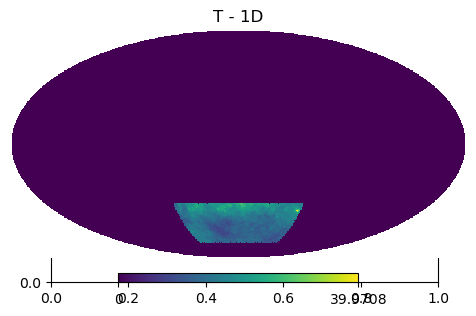

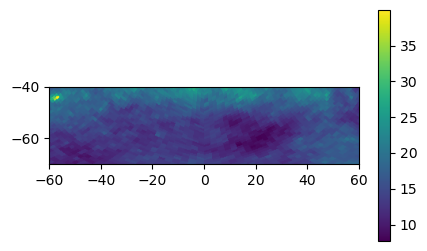

In [3]:
# patch
RA1 = -60 
RA2 = 60
dec1 = -70
dec2 = -40
idxs, resol = create_rectangular_patch([RA1, RA2], [dec1, dec2], nside)


map_array= [I40, Q40, U40, 
            I60, Q60, U60, 
            I78, Q78, U78, 
            I100, Q100, U100, 
            I140, Q140, U140, 
            I195, Q195, U195, 
            I280, Q280, U280, 
            I402, Q402, U402 ]


for map in map_array:

    visualize_patch = map.copy()

    mask = np.zeros_like(visualize_patch, dtype=bool)
    mask[idxs] = True

    #visualize_patch[~mask] = hp.UNSEEN

    map[~mask] = 0.0
    
########################################################################################

maps_2d = {}
extent=(RA1, RA2, dec1, dec2)

bands = ['40', '60', '78', '100', '140', '195', '280', '402']
types = ['I', 'Q', 'U']

'''
for band in bands:
    for map_type in types:


        map_name = f"{map_type}{band}"
        map_data = globals()[map_name] 
        variable_prefix = f"{map_type}{band}"
        
        CMB = f"{map_type}_map"
        
        mp_hp, ra_hp, dec_hp = convert2grid(map_data, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
        
        maps_2d[f"mp_hp_{variable_prefix}"] = mp_hp
        maps_2d[f"ra_hp_{variable_prefix}"] = ra_hp
        maps_2d[f"dec_hp_{variable_prefix}"] = dec_hp
        #print(f"Stored variables for: {variable_prefix}") 
'''

for band in bands:
    for map_type in types:
        # Construct the map names
        map_name = f"{map_type}{band}"
        #cmb_map_name = f"{map_type}_map"  
        
        
        map_data = globals()[map_name]
        
     
        #cmb_map = globals()[cmb_map_name]
        
        
        
        mp_hp, ra_hp, dec_hp = convert2grid(map_data, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
        
        # Store the converted maps
        variable_prefix = f"{map_type}{band}"
        maps_2d[f"mp_hp_{variable_prefix}"] = mp_hp #+ cmb_map
        maps_2d[f"ra_hp_{variable_prefix}"] = ra_hp
        maps_2d[f"dec_hp_{variable_prefix}"] = dec_hp
        
        # Optionally, you can print a confirmation message

#####################################################################################################
fig, ax = plt.subplots(figsize=(5, 3))
hp.mollview(I40, title='T - 1D', fig=fig.number)


plt.figure(figsize=(5, 3))
plt.imshow(maps_2d['mp_hp_I40'],origin='lower', extent=extent)
plt.colorbar()

In [4]:
Ny, Nx = np.shape(maps_2d['mp_hp_I40']) 
print(Nx, Ny)

X_width = Nx * pix_size/60
Y_width = Ny * pix_size/60

# color map
c_min, c_max     = -10, 10  


import random
num_simulations_beam = 2
num_simulations_angle = 3


frequencies = [40, 60, 78, 100, 140, 195, 280, 402]

I_maps = {
    40: maps_2d['mp_hp_I40'], 60: maps_2d['mp_hp_I60'], 78: maps_2d['mp_hp_I78'],
    100: maps_2d['mp_hp_I100'], 140: maps_2d['mp_hp_I140'], 195: maps_2d['mp_hp_I195'],
    280: maps_2d['mp_hp_I280'], 402: maps_2d['mp_hp_I402']}


Q_maps = {
    40: maps_2d['mp_hp_Q40'], 60: maps_2d['mp_hp_Q60'], 78: maps_2d['mp_hp_Q78'],
    100: maps_2d['mp_hp_Q100'], 140: maps_2d['mp_hp_Q140'], 195: maps_2d['mp_hp_Q195'],
    280: maps_2d['mp_hp_Q280'], 402: maps_2d['mp_hp_Q402']}

U_maps = {
    40: maps_2d['mp_hp_U40'], 60: maps_2d['mp_hp_U60'], 78: maps_2d['mp_hp_U78'],
    100: maps_2d['mp_hp_U100'], 140: maps_2d['mp_hp_U140'], 195: maps_2d['mp_hp_U195'],
    280: maps_2d['mp_hp_U280'], 402: maps_2d['mp_hp_U402']}

393 99


# Beam - MC
2 simulazioni

In [5]:

FWHM_err =np.sort([random.uniform(-0.1, 0.1) for _ in range(num_simulations_beam)])



###########################################################################################################

# COORDINATES LIKE THE ONES OF THE MAPS

Nx = int(Nx)
Ny = int(Ny)

onesx = np.ones(Nx)
onesy = np.ones(Ny)

indsx = (np.arange(Nx)+.5 - Nx/2.) * pix_size
indsy = (np.arange(Ny)+.5 - Ny/2.) * pix_size

X = np.outer(onesy, indsx)
Y = np.outer(indsy, onesx)
R = np.sqrt(X**2. + Y**2.)


#####################################################################################

# VARIABLES

FWHM_x = np.zeros(num_simulations_beam)
FWHM_y = np.zeros(num_simulations_beam)

for i in range (num_simulations_beam):
    FWHM_x[i] = 0.6  + FWHM_err[i] #degrees
    FWHM_y[i] = 0.8  + FWHM_err[i] #degrees

    
ellipticity = (FWHM_x - FWHM_y) / (FWHM_x + FWHM_y)
print("ellipticity = ", ellipticity)

array_dB = np.array([-20, -22, -24, -26]) #max values of the secondary peaks
array_dB = array_dB * 2.5
r1 = np.array([10000, 60000, 100000, 150000]) #angular distance of the peaks
r = 50 # width of the rings

theta = 0 # angle of rotation of the beam
a = 1 # major axis of ellipses 

#########################################################################################

# BEAM

beam_x = {}

for i in range(num_simulations_beam):
        _, _, _,_, beam_x[i], _ = create_beam_secpeaks(pix_size, FWHM_x[i], FWHM_y[i], theta, array_dB, r, r1, X, Y, a, ellipticity[i])
        

######################################################################################################


### beam systematics dictionary
bs = {"budy":{"A":1e-3,"FWHP":100,"R":700.,"psi":0.3,"polfracQ":0.5,"polfracU":0.01},  
                                                                         # little budy amplitude, 
                                                                         #FWHP, offset spacing, rotationa angle (radians)
                                                                        # pol_fraction for Q and U
     "ghostshelf": {"A":1e-4,"Diam":200.,"roll_off":7.},    #model of ghosting, amplitude (A), diameter (Diam) 
     "hex_crostalk":{"grid_space": 100.,"N":1,"neighbor_exp_fall":0.01}, 
                                                                               ## model of optical cross talk 
                                                                               ## to detectors on a hex grid
                                                                               ## assumed to be exponetial
                                                                               ## assumed to be 50% polarized
      "TtoQ":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
      "TtoU":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
                                                                  ## multiplole expansion leakage
      'psi':0.01*np.pi/180.
                                  ## detetor angle rotations
                   }

beam_sys = BeamSystematics()

beam_TT = {}
beam_QQ = {}
beam_UU = {}

for i in range(num_simulations_beam):
        beam_TT[i], beam_QQ[i], beam_UU[i], _, _, _, _ = make_systematics_beams_r(Nx, Ny, pix_size, FWHM_x[i], beam_x[i], bs)



ellipticity =  [-0.1481863  -0.14136919]


In [6]:
# convolution with perfect beam
perf_beam = {}
 

for i in range(num_simulations_beam):
    perf_beam[i], _, _, _, _, _ = create_beam_secpeaks(pix_size, FWHM_x[i], FWHM_y[i], 0, array_dB, r, r1, X, Y, a, ellipticity[i])
    perf_beam[i] = perf_beam[i] / np.sum(perf_beam[i])


Q_conv_perf_all = {}
U_conv_perf_all = {}

for freq in frequencies:
    Q_map = Q_maps[freq]
    U_map = U_maps[freq]

    Q_conv_perf  = np.zeros((num_simulations_beam, *Q_map.shape))
    U_conv_perf  = np.zeros((num_simulations_beam, *U_map.shape))

    
    for i in range(num_simulations_beam):
        Q_conv_perf[i, :, :] = convolve_map_with_beam(Q_map, perf_beam[i])
        U_conv_perf[i, :, :] = convolve_map_with_beam(U_map, perf_beam[i])
        
    Q_conv_perf_all[freq] = Q_conv_perf
    U_conv_perf_all[freq] = U_conv_perf

    
    
# convolution with real beam
Q_conv_real_all = {}
U_conv_real_all = {}
I_conv_real_all = {}
    
for freq in frequencies:
    Q_map = Q_maps[freq]
    U_map = U_maps[freq]
    I_map = I_maps[freq]

    I_conv_real  = np.zeros((num_simulations_beam, *I_map.shape))
    Q_conv_real  = np.zeros((num_simulations_beam, *Q_map.shape))
    U_conv_real  = np.zeros((num_simulations_beam, *U_map.shape))

    
    for i in range(num_simulations_beam):
        I_conv_real[i, :, :] = I_map #convolve_map_with_beam(I_map, beam_TT[i]) #I_map
        Q_conv_real[i, :, :] = Q_map #convolve_map_with_beam(Q_map, beam_QQ[i]) #Q_map
        U_conv_real[i, :, :] = U_map #convolve_map_with_beam(U_map, beam_UU[i]) #U_map
        
    I_conv_real_all[freq] = I_conv_real
    Q_conv_real_all[freq] = Q_conv_real
    U_conv_real_all[freq] = U_conv_real

In [7]:
np.shape(Q_conv_real_all[40])

(2, 99, 393)

# POLARIZATION ANGLE - MC
5 simulazioni

In [8]:
std_deviation_degree = 1
std_deviation_rad    = std_deviation_degree * np.pi / 180

gauss_center  = 0

pol_angle_given = [random.uniform(0.05, 0.5) for _ in range(num_simulations_angle)]  # deg
pol_angle_given = np.sort(pol_angle_given)

pol_angle_given_rad = np.zeros(num_simulations_angle)
for i in range (num_simulations_angle):
    pol_angle_given_rad[i] = pol_angle_given[i] * np.pi / 180



print(std_deviation_rad)
print(pol_angle_given_rad)
print(pol_angle_given)

#[0.07593096 0.21097913 0.31039778 0.35911768 0.42746707]

0.017453292519943295
[0.00171766 0.00374408 0.00791806]
[0.09841461 0.21452009 0.45367144]


In [9]:
def polangle_map(Q_map, U_map, pol_angle_given, gauss_center, std_deviation):
    error = np.random.normal(gauss_center, std_deviation, Q_map.shape)
    sign = np.random.choice([-1, 1], size=Q_map.shape)
    
    pol_angle = pol_angle_given + sign * error
    
    
    Q_map_pert = Q_map * np.cos(2 * pol_angle) + U_map * np.sin(2 * pol_angle)
    U_map_pert = U_map * np.cos(2 * pol_angle) + Q_map * np.sin(2 * pol_angle)
    
    return Q_map_pert, U_map_pert

In [10]:
Q_map_perturbed_all = {}
U_map_perturbed_all = {}

for freq in frequencies:
    Q_map = Q_conv_real_all[freq]
    U_map = U_conv_real_all[freq]

    Q_pert = np.zeros((num_simulations_beam, num_simulations_angle, 99, 393))
    U_pert = np.zeros((num_simulations_beam, num_simulations_angle, 99, 393))

    for i in range(num_simulations_beam):
        for j in range(num_simulations_angle):
            Q_pert[i, j, :, :], U_pert[i, j, :, :] = Q_conv_real_all[freq][i],U_conv_real_all[freq][i]#polangle_map(Q_conv_real_all[freq][i], U_conv_real_all[freq][i],pol_angle_given_rad[j], gauss_center, std_deviation_rad )
            #Q_conv_real_all[freq][i],U_conv_real_all[freq][i]
    # Store the perturbed maps in the dictionaries
    Q_map_perturbed_all[freq] = Q_pert
    U_map_perturbed_all[freq] = U_pert

In [11]:
np.shape(Q_map_perturbed_all[40])# beam, angle, mappa

(2, 3, 99, 393)

quindi ho una mappa 99x393 pixels, per 5 simulazioni di angolo per 5 simulazioni di beam

# APODIZZAZIONE

In [12]:
'''
window = (cosine_window_r(Nx, Ny, x_range=[-np.pi /4, np.pi /4], y_range=[-np.pi /4, np.pi /4]))

for freq in frequencies:
    for i in range(num_simulations_beam): # 1-4
        for j in range (num_simulations_angle): # 1-5
            Q_map_perturbed_all[freq][i][j] *= window
            U_map_perturbed_all[freq][i][j] *= window
        I_conv_real_all[freq][i] *= window
'''

'\nwindow = (cosine_window_r(Nx, Ny, x_range=[-np.pi /4, np.pi /4], y_range=[-np.pi /4, np.pi /4]))\n\nfor freq in frequencies:\n    for i in range(num_simulations_beam): # 1-4\n        for j in range (num_simulations_angle): # 1-5\n            Q_map_perturbed_all[freq][i][j] *= window\n            U_map_perturbed_all[freq][i][j] *= window\n        I_conv_real_all[freq][i] *= window\n'

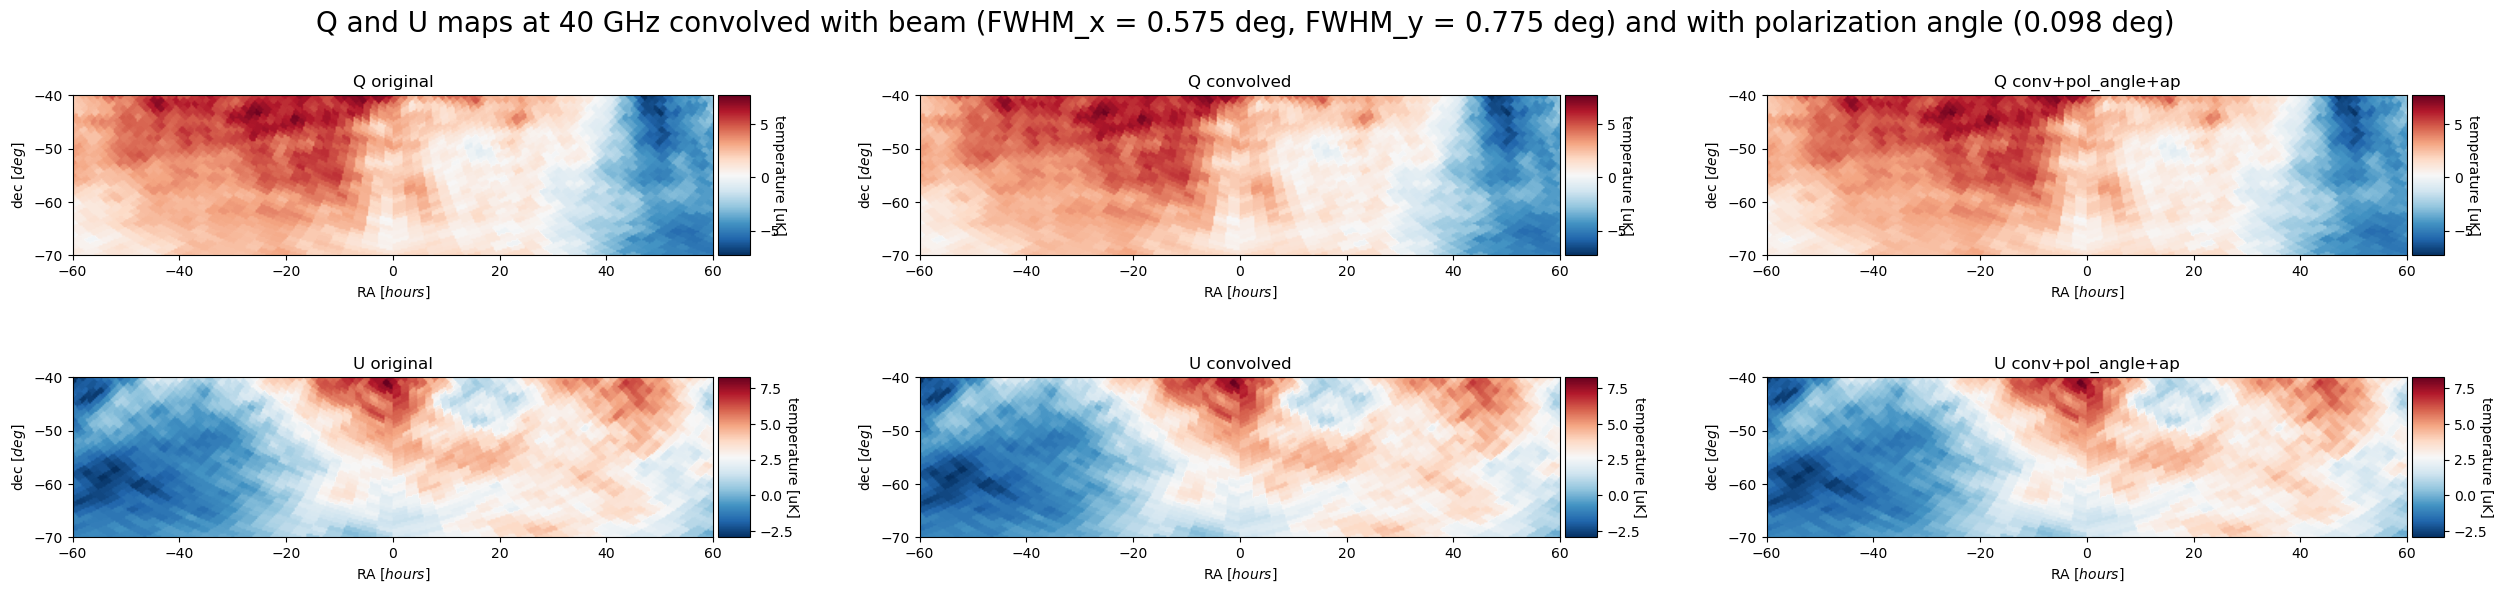

In [13]:
# plot - 1 frequenza (40) per una simulazione (1°)
Map_to_Plot = [maps_2d['mp_hp_Q40'], Q_conv_real_all[40][0], Q_map_perturbed_all[40][0][0], maps_2d['mp_hp_U40'], U_conv_real_all[40][0], U_map_perturbed_all[40][0][0]]
title = ["Q original","Q convolved", "Q conv+pol_angle+ap", "U original","U convolved", "U conv+pol_angle+ap"]
c_factor_max = [np.max(Map_to_Plot[0]), np.max(Map_to_Plot[1]), np.max(Map_to_Plot[2]), np.max(Map_to_Plot[3]), np.max(Map_to_Plot[4]), np.max(Map_to_Plot[5])]
c_factor_min = [np.min(Map_to_Plot[0]), np.min(Map_to_Plot[1]), np.min(Map_to_Plot[2]), np.min(Map_to_Plot[3]), np.min(Map_to_Plot[4]), np.min(Map_to_Plot[5])]

fig, axs = plt.subplots(2, 3, figsize=(25, 6))
axs      = axs.flatten()
tipo = 'coords' # plott in coordinate RA- dec invece di dimensioni in degree
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
        Plot_CMB_Map_compact(axs[i], map_data, c_factor_iter_min, c_factor_iter_max, X_width, Y_width, extent, tipo)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle(f'Q and U maps at {frequencies[0]} GHz convolved with beam (FWHM_x = {(FWHM_x[0]):.3f} deg, FWHM_y = {(FWHM_y[0]):.3f} deg) and with polarization angle ({(pol_angle_given[0]):.3f} deg)', fontsize=20)
#plt.savefig('/Users/guide/Documents/University/TESI/immagini/FullModelPerturbation.png')
plt.show()

# COMPONENT SEPARATION
Trasformo in 1D, unisco le 8 frequenza per ogni simulazione, component separation

In [17]:
idx = hp.ang2pix(nside, ra_hp, dec_hp, lonlat=True)


Q_flat_all = {}
U_flat_all = {}
I_flat_all = {}

for freq in frequencies:
    Q_map = Q_map_perturbed_all[freq]
    U_map = U_map_perturbed_all[freq]
    I_map = I_conv_real_all[freq]
    
    Q_map_flat  = np.zeros((num_simulations_beam, num_simulations_angle,*I40.shape))
    U_map_flat  = np.zeros((num_simulations_beam, num_simulations_angle,*I40.shape))
    I_map_flat  = np.zeros((num_simulations_beam,*I40.shape))
    
    for i in range(num_simulations_beam):
        new_map_I = np.zeros_like(I40) 
        new_map_I[idx] = I_conv_real_all[freq][i].flatten()
        I_map_flat[i] = new_map_I  # Store the new map in the flat array
        
    
        for j in range (num_simulations_angle): # 1-5
        
            new_map_Q = np.zeros_like(I40) 
            new_map_Q[idx] = Q_map_perturbed_all[freq][i][j].flatten()
            Q_map_flat[i][j] = new_map_Q  # Store the new map in the flat array
        
        
            new_map_U = np.zeros_like(I40) 
            new_map_U[idx] = U_map_perturbed_all[freq][i][j].flatten()
            U_map_flat[i][j] = new_map_U
        
        
    Q_flat_all[freq] = Q_map_flat
    U_flat_all[freq] = U_map_flat 
    I_flat_all[freq] = I_map_flat
    
    
    
n_pixels   = I40.size
full_array = np.zeros((len(frequencies), 2, num_simulations_beam, num_simulations_angle, n_pixels)) #3


for f_idx, freq in enumerate(frequencies):
    Q_stack = Q_flat_all[freq]
    U_stack = U_flat_all[freq]
    
    #I_expanded = np.expand_dims(I_flat_all[freq], axis=1)  # Aggiungi una dimensione per gli angoli di polarizzazione
    #I_expanded = np.tile(I_expanded, (1, num_simulations_angle, 1))
   
    
    for j in range (num_simulations_angle):
        freq_stack = np.stack([Q_stack, U_stack], axis=0)  # I_expanded


    full_array[f_idx] = freq_stack


print(full_array.shape)  # Expected shape: (8, 2, 4, 5, 49152)

# different shape
full_array = full_array.transpose(2, 3, 0, 1, 4)
print(full_array.shape)  # Expected shape: (4, 5, 8, 2, 49152)

(8, 2, 2, 3, 49152)
(2, 3, 8, 2, 49152)


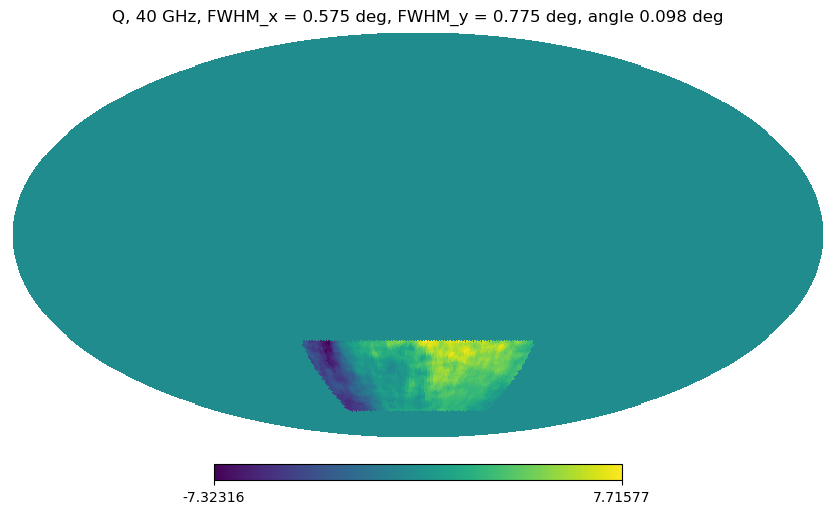

In [18]:
# mappa Q, 40 GHz, beam 1 angolo 1
hp.mollview(full_array[0][0][0][0], title=f'Q, 40 GHz, FWHM_x = {(FWHM_x[0]):.3f} deg, FWHM_y = {(FWHM_y[0]):.3f} deg, angle {(pol_angle_given[0]):.3f} deg')

In [19]:
instrument = get_instrument('LiteBIRD')

df   = pd.DataFrame(instrument)
instrument_freq = df.iloc[[0, 2, 4, 6, 8, 10, 12, 14], :]   #estraggo le frequenze che ho selezionato creando le patch


In [20]:
components = [CMB(), Dust(350.), Synchrotron(20.)]
results = []
cmb_Q = {}
cmb_U = {}
cmb_I = {}

for i in range(num_simulations_beam):
    cmb_Q[i] = {}
    cmb_U[i] = {}
    #cmb_I[i] = {}
    for j in range(num_simulations_angle):
        result = basic_comp_sep(components, instrument_freq, full_array[i][j])
        results.append(result)

        print(f"Beam Simulation {i}, Angle Simulation {j}")
        print(result.x)
        print('\n')

        cmb_Q[i][j] = result.s[0, 0] # 0
        cmb_U[i][j] = result.s[0, 1] # 1
        #cmb_I[i][j] = result.s[0, 0]

Beam Simulation 0, Angle Simulation 0
[ 1.53999989 20.         -3.00000001]


Beam Simulation 0, Angle Simulation 1
[ 1.53999989 20.         -3.00000001]


Beam Simulation 0, Angle Simulation 2
[ 1.53999989 20.         -3.00000001]


Beam Simulation 1, Angle Simulation 0
[ 1.53999989 20.         -3.00000001]


Beam Simulation 1, Angle Simulation 1
[ 1.53999989 20.         -3.00000001]


Beam Simulation 1, Angle Simulation 2
[ 1.53999989 20.         -3.00000001]




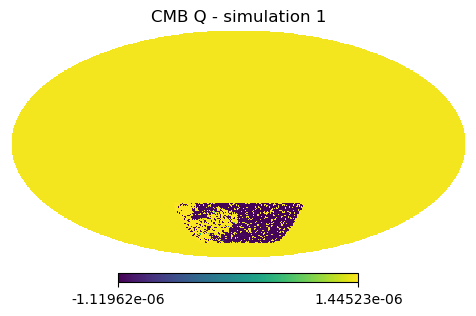

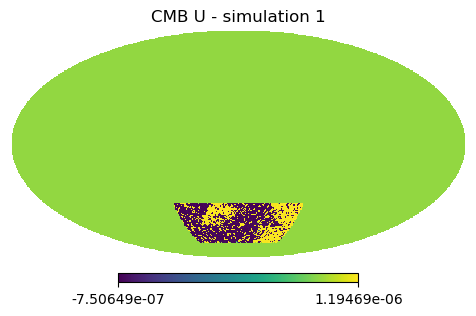

In [21]:
plt.figure(figsize=(5, 3))
hp.mollview(cmb_Q[0][0], title='CMB Q - simulation 1', norm='hist', fig=fig.number)
plt.show()

plt.figure(figsize=(5, 3))
hp.mollview(cmb_U[0][0], title='CMB U - simulation 1', norm='hist', fig=fig.number)
plt.show()

#plt.figure(figsize=(5, 3))
#hp.mollview(cmb_I[0][0], title='CMB T - simulation 1', norm='hist', fig=fig.number)
#plt.show()


In [24]:
cmb_Q[0][0][:200] # sono 0

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# DECONVOLUTION
Torno in 2D, deconvolvo

In [25]:
cmb_Q_2d = {}
cmb_U_2d = {}
cmb_I_2d = {}

def safe_convert2grid(data, nside, resol, ra_range, dec_range, method, fill_nan):
    if data.size == 0:
        raise ValueError("Input data is empty.")
    
    reproj_map, ra_hp, dec_hp = convert2grid(data, nside, resol, ra_range, dec_range, method, fill_nan)
    
    if np.isnan(reproj_map).all():
        raise ValueError("Reprojected map is all NaNs.")
    
    return reproj_map, ra_hp, dec_hp

for i in range(num_simulations_beam):
    cmb_Q_2d[i] = {}
    cmb_U_2d[i] = {}
    cmb_I_2d[i] = {}
    for j in range(num_simulations_angle):
        try:
            cmb_Q_2d[i][j], ra_hp, dec_hp = safe_convert2grid(cmb_Q[i][j], nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
            #cmb_I_2d[i][j], ra_hp, dec_hp = safe_convert2grid(cmb_I[i][j], nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
            cmb_U_2d[i][j], ra_hp, dec_hp = safe_convert2grid(cmb_U[i][j], nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
        
        except ValueError as e:
            print(f"Error processing Beam {i+1}, Angle {j+1}: {e}")
            continue



In [26]:
Q_deconv = {}
U_deconv = {}
I_deconv = {}

for i in range (num_simulations_beam):
    Q_deconv[i] = {}
    U_deconv[i] = {}
    #I_deconv[i] = {}
    for j in range (num_simulations_angle):
        Q_deconv[i][j] =  cmb_Q_2d[i][j]#deconvolve_map(cmb_Q_2d[i][j], beam_x[i], perf_beam[i]) #cmb_Q_2d[i][j]
        #I_deconv[i][j] = deconvolve_map(cmb_I_2d[i][j], beam_x[i], perf_beam[i])
        U_deconv[i][j] =  cmb_U_2d[i][j]#deconvolve_map(cmb_U_2d[i][j], beam_x[i], perf_beam[i]) #cmb_U_2d[i][j]
    

########################################################################################
# side lobes

Q_conv_perf = {}
U_conv_perf = {}
Q_diff = {}
U_diff = {}

for i in range (num_simulations_beam):
    Q_diff[i] = {}
    U_diff[i] = {}
    Q_conv_perf[i] = {}
    U_conv_perf[i] = {}
    for j in range (num_simulations_angle):
        Q_conv_perf[i][j] = convolve_map_with_beam(cmb_Q_2d[i][j], perf_beam[i])
        U_conv_perf[i][j] = convolve_map_with_beam(cmb_U_2d[i][j], perf_beam[i])
    
        Q_diff[i][j] = (Q_conv_perf[i][j]- Q_deconv[i][j])
        U_diff[i][j] = (U_conv_perf[i][j]- U_deconv[i][j])

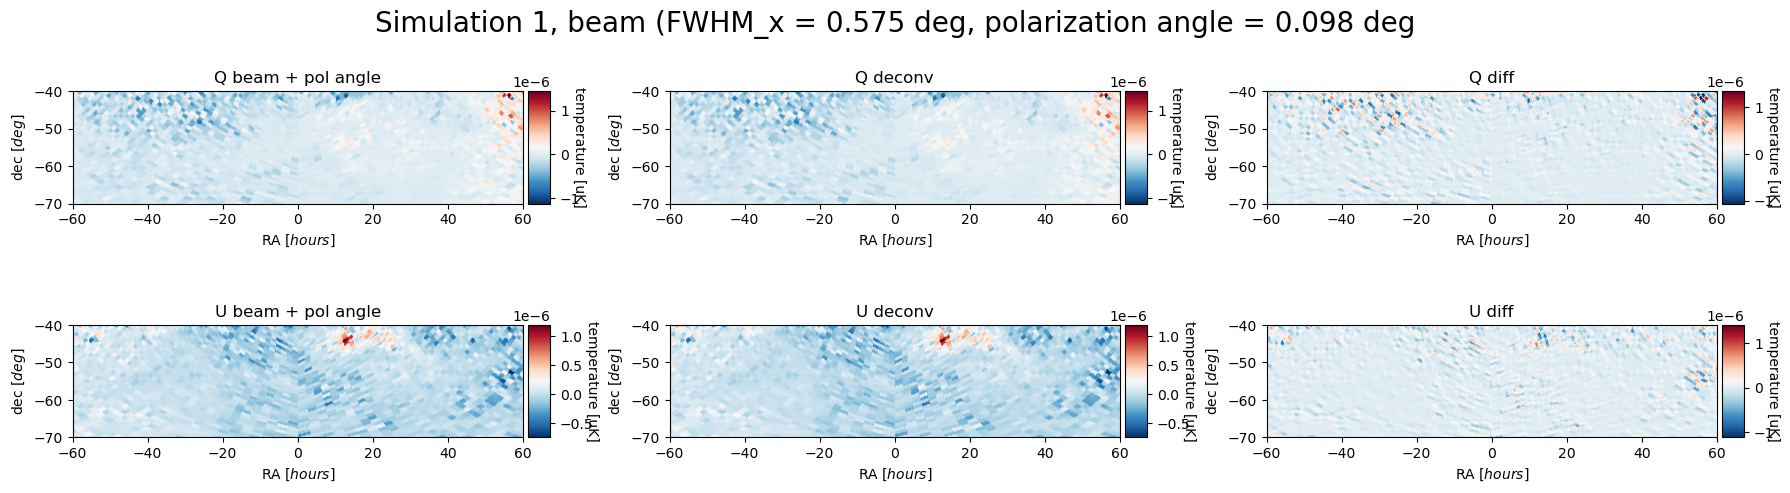

In [27]:
Map_to_Plot = [cmb_Q_2d[0][0],Q_deconv[0][0], Q_diff[0][0], cmb_U_2d[0][0] ,U_deconv[0][0], U_diff[0][0]]
title = ["Q beam + pol angle", "Q deconv", "Q diff", "U beam + pol angle", "U deconv", "U diff"]
c_factor_max = [np.max(Map_to_Plot[0]), np.max(Map_to_Plot[1]), np.max(Map_to_Plot[2]), np.max(Map_to_Plot[3]), np.max(Map_to_Plot[4]), np.max(Map_to_Plot[5])]
c_factor_min = [np.min(Map_to_Plot[0]), np.min(Map_to_Plot[1]), np.min(Map_to_Plot[2]), np.min(Map_to_Plot[3]), np.min(Map_to_Plot[4]), np.min(Map_to_Plot[5])]



fig, axs = plt.subplots(2, 3, figsize=(18, 5))
axs      = axs.flatten()
tipo = 'coords' # plot in coordinate RA- dec invece di dimensioni in degree
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
        Plot_CMB_Map_compact(axs[i], map_data, c_factor_iter_min, c_factor_iter_max, X_width, Y_width,extent, tipo)
        axs[i].set_title(title[i])
        
    

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle(f'Simulation 1, beam (FWHM_x = {(FWHM_x[0]):.3f} deg, polarization angle = {pol_angle_given[0]:.3f} deg', fontsize=20)
plt.show()

# POWER SPECTRA 
Con Namaster

In [28]:
pix_size_rad = np.radians(pix_size /60)

X_width_rad = Nx * pix_size_rad
Y_width_rad = Ny * pix_size_rad


# Masks:
mask = np.ones_like(Q_deconv[0][0])

# bins


l0_bins = np.arange(Nx/8) * 8 * np.pi/X_width_rad
lf_bins = (np.arange(Nx/8)+1) * 8 * np.pi/X_width_rad


b = nmt.NmtBinFlat(l0_bins, lf_bins)

# The effective sampling rate for these bandpowers can be obtained calling:
ells_uncoupled = b.get_effective_ells()

TT_PS = {}
BB_PS = {}
EE_PS = {}

from tqdm import tqdm
for i in tqdm(range(num_simulations_beam)):
    TT_PS[i] = {}
    BB_PS[i] = {}
    EE_PS[i] = {}
    for j in range (num_simulations_angle):
        
        #I = I_deconv[i][j]
        Q = Q_deconv[i][j]
        U = U_deconv[i][j]
        
        f2 = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [Q, U], purify_b=True)
        #f0 = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [I])
        
        #w00 = nmt.NmtWorkspaceFlat()
        #w00.compute_coupling_matrix(f0, f0, b)
        #w02 = nmt.NmtWorkspaceFlat()
        #w02.compute_coupling_matrix(f0, f2, b)
        w22 = nmt.NmtWorkspaceFlat()
        w22.compute_coupling_matrix(f2, f2, b)
   
        cl22_coupled = nmt.compute_coupled_cell_flat(f2, f2, b)
    
        #cl00_coupled = nmt.compute_coupled_cell_flat(f0, f0, b)
        #cl00_uncoupled = w00.decouple_cell(cl00_coupled)
        #cl02_coupled = nmt.compute_coupled_cell_flat(f0, f2, b)
        #cl02_uncoupled = w02.decouple_cell(cl02_coupled)
        cl22_coupled = nmt.compute_coupled_cell_flat(f2, f2, b)
        cl22_uncoupled = w22.decouple_cell(cl22_coupled)

        #TT_PS[i][j] = cl00_uncoupled[0]
        EE_PS[i][j] = cl22_coupled[0]
        BB_PS[i][j] = cl22_coupled[3]
        #EE_PS[i][j] = cl22_coupled[0]
        #BB_PS[i][j] = cl22_coupled[3]

100%|██████████| 2/2 [00:18<00:00,  9.19s/it]


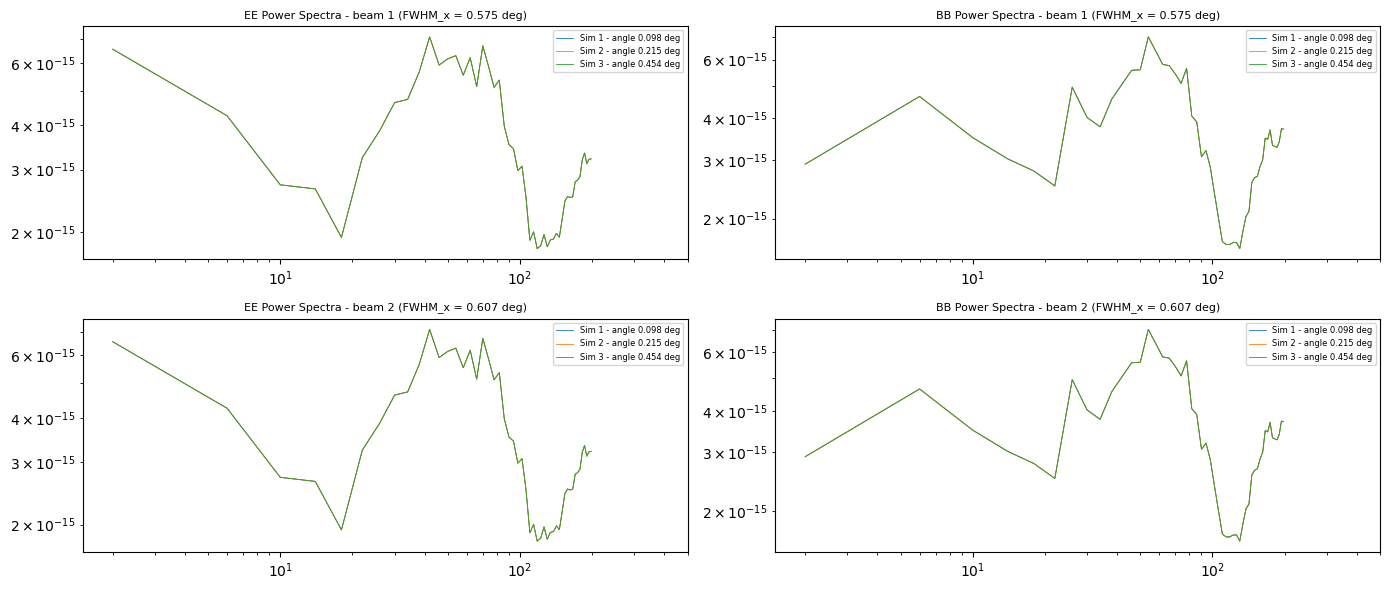

In [29]:
fig, ax = plt.subplots(num_simulations_beam, 2, figsize=(14, 3 * num_simulations_beam))
factor = ells_uncoupled*(ells_uncoupled+1) /(2*np.pi)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for b in range(num_simulations_beam):
    # Plot EE power spectra
    ax[b, 0].set_title(f'EE Power Spectra - beam {b+1} (FWHM_x = {FWHM_x[b]:.3f} deg)', fontsize = 8)

    for i in range(num_simulations_angle):
        color = colors[i % len(colors)]
        ax[b, 0].plot(ells_uncoupled, EE_PS[b][i] * factor, color=color, linewidth=0.6, label=f'Sim {i+1} - angle {pol_angle_given[i]:.3f} deg')
    
    ax[b, 0].loglog()
    ax[b, 0].legend(fontsize=6)
    ax[b, 0].set_xlim(1.5, 500)

    # Plot BB power spectra
    ax[b, 1].set_title(f'BB Power Spectra - beam {b+1} (FWHM_x = {FWHM_x[b]:.3f} deg)', fontsize = 8)

    for i in range(num_simulations_angle):
        color = colors[i % len(colors)]
        ax[b, 1].plot(ells_uncoupled, BB_PS[b][i] * factor, color=color, linewidth=0.6, label=f'Sim {i+1} - angle {pol_angle_given[i]:.3f} deg')
    
    ax[b, 1].loglog()
    ax[b, 1].legend(fontsize=6)
    ax[b, 1].set_xlim(1.5, 500)


plt.tight_layout()
plt.show()

# Confronto PS
Confronto il PS trovato con quello originato con CAMB e l'r trovato

In [30]:
r0 = 0.001

pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=r0)
pars.set_for_lmax(2500, lens_potential_accuracy=0) # 2500
pars.WantTensors= True

results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')


totCL = powers['total']

unlensedCL = powers['unlensed_scalar']
unlensedtotal = powers['unlensed_total']
tensor = powers['tensor']

ls = np.arange(totCL.shape[0])

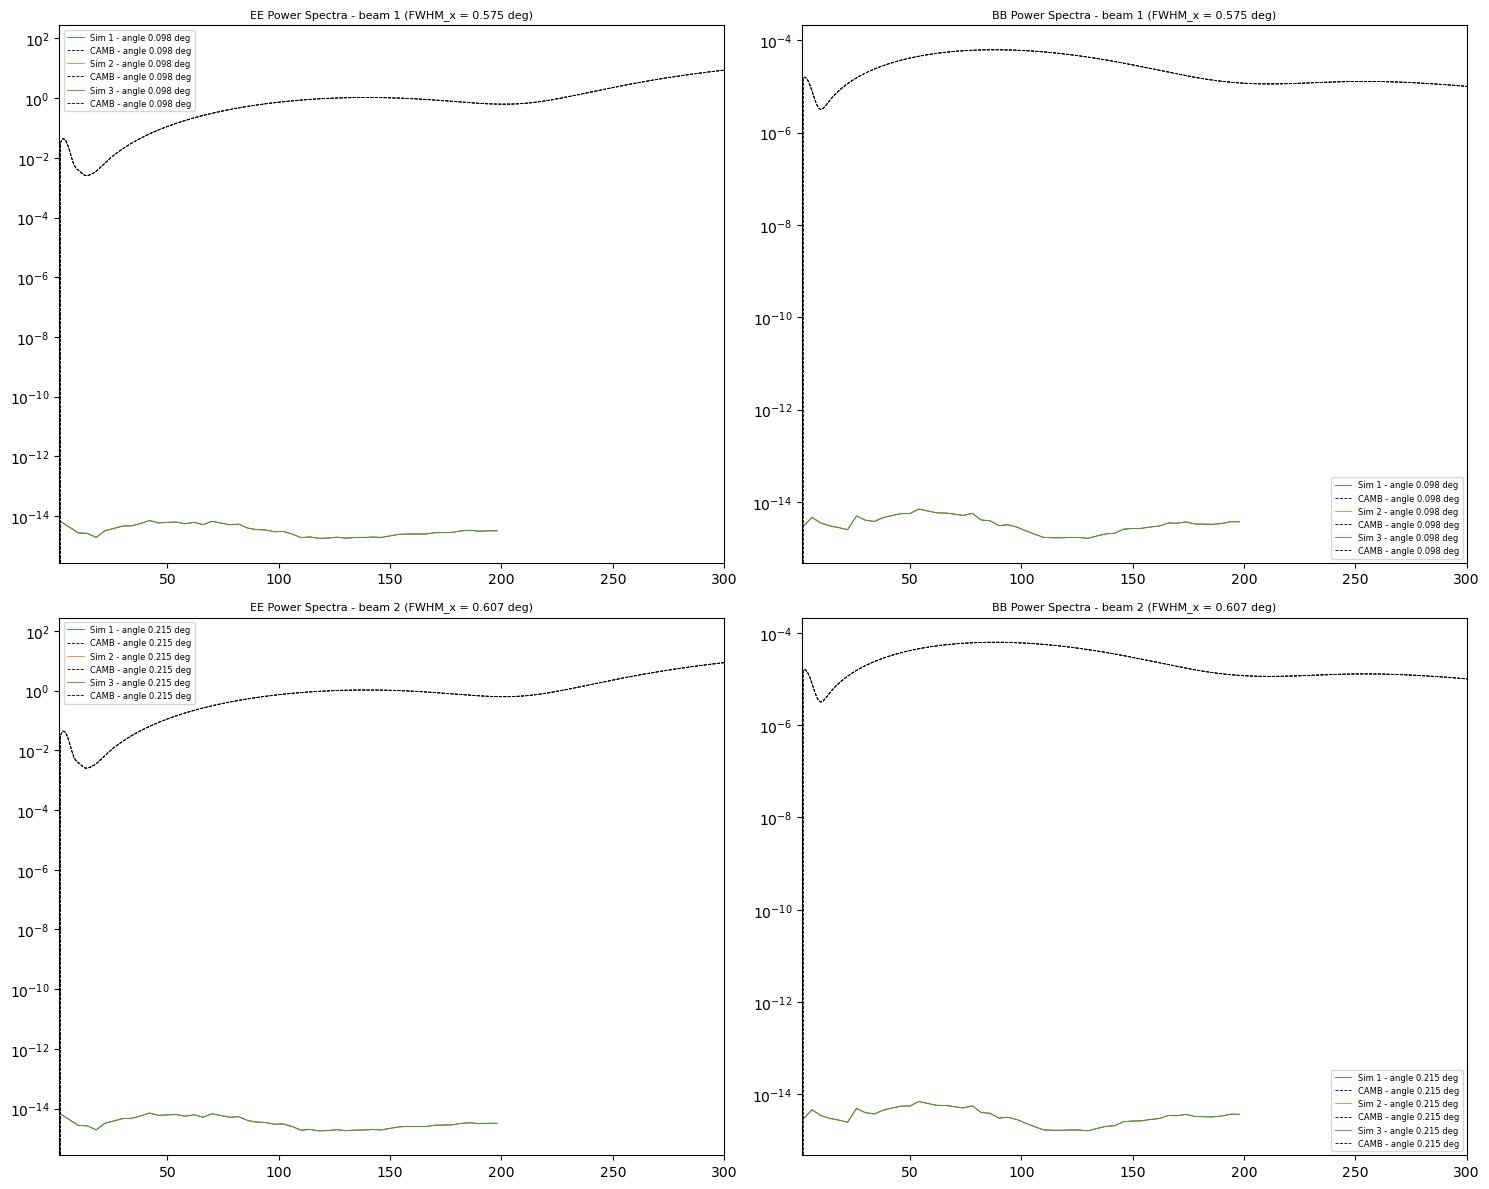

In [31]:
# PLOTTO DL - 
# namaster e camb danno cl

fig, ax = plt.subplots(num_simulations_beam, 2, figsize=(15, 6 * num_simulations_beam))
factor      = ells_uncoupled*(ells_uncoupled+1) /(2*np.pi)
factor_camb = ls*(ls+1) /(2*np.pi)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for i in range(num_simulations_beam):
    # Plot EE power spectra
    ax[i, 0].set_title(f'EE Power Spectra - beam {i+1} (FWHM_x = {FWHM_x[i]:.3f} deg)', fontsize = 8)

    for j in range(num_simulations_angle):
        color = colors[j % len(colors)]
        ax[i, 0].plot(ells_uncoupled, EE_PS[i][j] * factor, color=color, linewidth=0.6, label=f'Sim {j+1} - angle {pol_angle_given[i]:.3f} deg')
        ax[i, 0].plot(ls, unlensedtotal[:,1] , color='black', linewidth=0.6, label=f'CAMB - angle {pol_angle_given[i]:.3f} deg', linestyle='--')

    
    ax[i, 0].semilogy()
    ax[i, 0].legend(fontsize=6)
    ax[i, 0].set_xlim(1.5, 300)
   # ax[i, 0].set_ylim(5e-4, 1e-2)


    # Plot BB power spectra
    ax[i, 1].set_title(f'BB Power Spectra - beam {i+1} (FWHM_x = {FWHM_x[i]:.3f} deg)', fontsize = 8)

    for j in range(num_simulations_angle):
        color = colors[j % len(colors)]
        ax[i, 1].plot(ells_uncoupled, BB_PS[i][j] * factor, color=color, linewidth=0.6, label=f'Sim {j+1} - angle {pol_angle_given[i]:.3f} deg')
        ax[i, 1].plot(ls, unlensedtotal[:,2] , color='black', linewidth=0.6, label=f'CAMB - angle {pol_angle_given[i]:.3f} deg', linestyle='--')
    
    ax[i, 1].semilogy()
    ax[i, 1].legend(fontsize=6)
    ax[i, 1].set_xlim(1.5, 300)
    #ax[i, 1].set_ylim(5e-4, 1e-2)



plt.tight_layout()
plt.savefig('PS_cmbd0s0_unseen.png')

plt.show()

# r forecast

In [32]:
def cosmological_likelihood(Cls_, fsky, r_input, fisher):
    import bisect
    from fgbuster.cosmology import _get_Cl_cmb
    """
    This function returns the c.l. from
    the likelihood on r provided Cls
    :param Cls_: Cls^stat from comp sep
            note: they must start from l=2
    :param fsky: percentage of the sky to use
    :param r_input: assumed value of r
    :param fisher: return 68% confidence level on r or sigma(r) from fisher
    :return sigma_r: 68% confidence level on r or sigma from fisher
    """
    lmax = len(Cls_)
    ell = np.arange(2, lmax + 2)

    # values of r over which the likelihood is computed
    if r_input >= 0.005:
        r_max = 2*r_input
    else:
        r_max = 0.01
    r_v = np.linspace(0.000, r_max, num=10 ** 6)
    r_v = r_v.tolist()
    # add r_input in r_v
    if r_input not in r_v:
        bisect.insort(r_v, r_input)
    r_v = np.array(r_v)

    ClBBr1 = _get_Cl_cmb(0.0, 1.0)[2][2:lmax + 2]
    ClBBlens = _get_Cl_cmb(1.0, 0.0)[2][2:lmax + 2]
    Data = ClBBlens + Cls_ + _get_Cl_cmb(0.0, r_input)[2][2:lmax+2]

    if fisher:
        # computing sigma(r=r_input) from fisher
        F = np.sum((2 * ell + 1) * fsky / 2 * ClBBr1 ** 2 / Data ** 2)
        sigma_r_fisher = np.sqrt(1.0 / F)

        return sigma_r_fisher

    else:
        # gridding the likelihood
        logL = np.array([np.sum((2 * ell + 1) / 2 * fsky * (np.log(ClBBr1 * r_ + ClBBlens + Cls_)
                                                                + Data / (ClBBr1 * r_ + ClBBlens + Cls_))) for r_ in r_v])
        L = np.exp(-(logL - np.min(logL)))
        # computing sigma(r=r_input) as the 68% confidence level on r
        rs_pos = r_v[r_v > r_input]
        plike_pos = L[r_v > r_input]
        cum = np.cumsum(plike_pos)
        cum /= cum[-1]
        sigma_r = rs_pos[np.argmin(np.abs(cum - 0.68))]

    return sigma_r

In [33]:
def xForecast(components, instrument, d_fgs, lmin, lmax,
              Alens=1.0, r=0.001, make_figure=False,
              **minimize_kwargs):
    from fgbuster import  CMB, Dust, Synchrotron, algebra, mixingmatrix, observation_helpers
    import os.path as op
    import numpy as np
    import pylab as pl
    import healpy as hp
    import scipy as sp
    from fgbuster.algebra import comp_sep, W_dBdB, W_dB, W, _mmm, _utmv, _mmv
    from fgbuster.mixingmatrix import MixingMatrix
    from fgbuster.observation_helpers import standardize_instrument
    from fgbuster.cosmology import _get_Cl_noise,_get_Cl_cmb
    import inspect
    from time import time
    import six
    import numpy as np
    import scipy as sp
    import numdifftools
    from functools import reduce
   
    
    # Preliminaries
    instrument = standardize_instrument(instrument)
    nside = hp.npix2nside(d_fgs.shape[-1])
    n_stokes = d_fgs.shape[1]
    n_freqs = d_fgs.shape[0]
    invN = np.diag(hp.nside2resol(nside, arcmin=True) / (instrument.depth_p))**2
    mask = d_fgs[0, 0, :] != 0.
    fsky = mask.astype(float).sum() / mask.size
    ell = np.arange(lmin, lmax+1)
    #print('fsky = ', fsky)

    ############################################################################
    # 1. Component separation using the noise-free foregrounds templare
    # grab the max-L spectra parameters with the associated error bars
    #print('======= ESTIMATION OF SPECTRAL PARAMETERS =======')
    A = MixingMatrix(*components)
    A_ev = A.evaluator(instrument.frequency)
    A_dB_ev = A.diff_evaluator(instrument.frequency)

    x0 = np.array([x for c in components for x in c.defaults])
    if n_stokes == 3:  # if T and P were provided, extract P
        d_comp_sep = d_fgs[:, 1:, :]
    else:
        d_comp_sep = d_fgs

    res = comp_sep(A_ev, d_comp_sep.T, invN, A_dB_ev, A.comp_of_dB, x0,
                   **minimize_kwargs)

    res.params = A.params
    res.s = res.s.T
    A_maxL = A_ev(res.x)
    A_dB_maxL = A_dB_ev(res.x)
    A_dBdB_maxL = A.diff_diff_evaluator(instrument.frequency)(res.x)

    #print('res.x = ', res.x)

    ############################################################################
    # 2. Estimate noise after component separation
    ### A^T N_ell^-1 A
    #print('======= ESTIMATION OF NOISE AFTER COMP SEP =======')
    i_cmb = A.components.index('CMB')
    Cl_noise = _get_Cl_noise(instrument, A_maxL, lmax)[i_cmb, i_cmb, lmin:]

    ############################################################################
    # 3. Compute spectra of the input foregrounds maps
    ### TO DO: which size for Cl_fgs??? N_spec != 1 ? 
    #print ('======= COMPUTATION OF CL_FGS =======')
    if n_stokes == 3:  
        d_spectra = d_fgs
    else:  # Only P is provided, add T for map2alm
        d_spectra = np.zeros((n_freqs, 3, d_fgs.shape[2]), dtype=d_fgs.dtype)
        d_spectra[:, 1:] = d_fgs

    # Compute cross-spectra
    almBs = [hp.map2alm(freq_map, lmax=lmax, iter=10)[2] for freq_map in d_spectra]
    Cl_fgs = np.zeros((n_freqs, n_freqs, lmax+1), dtype=d_fgs.dtype)
    for f1 in range(n_freqs):
        for f2 in range(n_freqs):
            if f1 > f2:
                Cl_fgs[f1, f2] = Cl_fgs[f2, f1]
            else:
                Cl_fgs[f1, f2] = hp.alm2cl(almBs[f1], almBs[f2], lmax=lmax)

    Cl_fgs = Cl_fgs[..., lmin:] / fsky

    ############################################################################
    # 4. Estimate the statistical and systematic foregrounds residuals
    #print('======= ESTIMATION OF STAT AND SYS RESIDUALS =======')

    W_maxL = W(A_maxL, invN=invN)[i_cmb, :]
    W_dB_maxL = W_dB(A_maxL, A_dB_maxL, A.comp_of_dB, invN=invN)[:, i_cmb]
    W_dBdB_maxL = W_dBdB(A_maxL, A_dB_maxL, A_dBdB_maxL,
                         A.comp_of_dB, invN=invN)[:, :, i_cmb]
    V_maxL = np.einsum('ij,ij...->...', res.Sigma, W_dBdB_maxL)

    # Check dimentions
    assert ((n_freqs,) == W_maxL.shape == W_dB_maxL.shape[1:]
                       == W_dBdB_maxL.shape[2:] == V_maxL.shape)
    assert (len(res.params) == W_dB_maxL.shape[0] 
                            == W_dBdB_maxL.shape[0] == W_dBdB_maxL.shape[1])

    # elementary quantities defined in Stompor, Errard, Poletti (2016)
    Cl_xF = {}
    Cl_xF['yy'] = _utmv(W_maxL, Cl_fgs.T, W_maxL)  # (ell,)
    Cl_xF['YY'] = _mmm(W_dB_maxL, Cl_fgs.T, W_dB_maxL.T)  # (ell, param, param)
    Cl_xF['yz'] = _utmv(W_maxL, Cl_fgs.T, V_maxL )  # (ell,)
    Cl_xF['Yy'] = _mmv(W_dB_maxL, Cl_fgs.T, W_maxL)  # (ell, param)
    Cl_xF['Yz'] = _mmv(W_dB_maxL, Cl_fgs.T, V_maxL)  # (ell, param)

    # bias and statistical foregrounds residuals
    res.noise = Cl_noise
    res.bias = Cl_xF['yy'] + 2 * Cl_xF['yz']  # S16, Eq 23
    res.stat = np.einsum('ij, lij -> l', res.Sigma, Cl_xF['YY'])  # E11, Eq. 12
    res.var = res.stat**2 + 2 * np.einsum('li, ij, lj -> l', # S16, Eq. 28
                                          Cl_xF['Yy'], res.Sigma, Cl_xF['Yy'])

    ###############################################################################
    # 5. Plug into the cosmological likelihood
    #print ('======= OPTIMIZATION OF COSMO LIKELIHOOD =======')
    Cl_fid = {}
    Cl_fid['BB'] = _get_Cl_cmb(Alens=Alens, r=r)[2][lmin:lmax+1]
    Cl_fid['BuBu'] = _get_Cl_cmb(Alens=0.0, r=1.0)[2][lmin:lmax+1]
    Cl_fid['BlBl'] = _get_Cl_cmb(Alens=1.0, r=0.0)[2][lmin:lmax+1]

    res.BB = Cl_fid['BB']*1.0
    res.BuBu = Cl_fid['BuBu']*1.0
    res.BlBl = Cl_fid['BlBl']*1.0
    res.ell = ell
    if make_figure:
        fig = pl.figure( figsize=(14,12), facecolor='w', edgecolor='k' )
        ax = pl.gca()
        left, bottom, width, height = [0.2, 0.2, 0.15, 0.2]
        ax0 = fig.add_axes([left, bottom, width, height])
        ax0.set_title(r'$\ell_{\min}=$'+str(lmin)+\
            r'$ \rightarrow \ell_{\max}=$'+str(lmax), fontsize=16)

        ax.loglog(ell, Cl_fid['BB'], color='DarkGray', linestyle='-', label='BB tot', linewidth=2.0)
        ax.loglog(ell, Cl_fid['BuBu']*r , color='DarkGray', linestyle='--', label='primordial BB for r='+str(r), linewidth=2.0)
        ax.loglog(ell, res.stat, 'DarkOrange', label='statistical residuals', linewidth=2.0)
        ax.loglog(ell, res.bias, 'DarkOrange', linestyle='--', label='systematic residuals', linewidth=2.0)
        ax.loglog(ell, res.noise, 'DarkBlue', linestyle='--', label='noise after component separation', linewidth=2.0)
        ax.legend()
        ax.set_xlabel('$\ell$', fontsize=20)
        ax.set_ylabel('$C_\ell$ [$\mu$K-arcmin]', fontsize=20)
        ax.set_xlim(lmin,lmax)

    ## 5.1. data 
    Cl_obs = Cl_fid['BB'] + Cl_noise
    dof = (2 * ell + 1) * fsky
    YY = Cl_xF['YY']
    tr_SigmaYY = np.einsum('ij, lji -> l', res.Sigma, YY)

    ## 5.2. modeling
    def cosmo_likelihood(r_):
        # S16, Appendix C
        Cl_model = Cl_fid['BlBl'] * Alens + Cl_fid['BuBu'] * r_ + Cl_noise
        dof_over_Cl = dof / Cl_model
        ## Eq. C3
        U = np.linalg.inv(res.Sigma_inv + np.dot(YY.T, dof_over_Cl))
        
        ## Eq. C9
        first_row = np.sum(dof_over_Cl * (
            Cl_obs * (1 - np.einsum('ij, lji -> l', U, YY) / Cl_model) 
            + tr_SigmaYY))
        second_row = - np.einsum(
            'l, m, ij, mjk, kf, lfi',
            dof_over_Cl, dof_over_Cl, U, YY, res.Sigma, YY)
        trCinvC = first_row + second_row
       
        ## Eq. C10
        first_row = np.sum(dof_over_Cl * (Cl_xF['yy'] + 2 * Cl_xF['yz']))
        ### Cyclicity + traspose of scalar + grouping terms -> trace becomes
        ### Yy_ell^T U (Yy + 2 Yz)_ell'
        trace = np.einsum('li, ij, mj -> lm',
                          Cl_xF['Yy'], U, Cl_xF['Yy'] + 2 * Cl_xF['Yz'])
        second_row = - _utmv(dof_over_Cl, trace, dof_over_Cl)
        trECinvC = first_row + second_row

        ## Eq. C12
        logdetC = np.sum(dof * np.log(Cl_model)) - np.log(np.linalg.det(U))

        return trCinvC + trECinvC + logdetC


    # Likelihood maximization
    r_grid = np.logspace(-5,0,num=500)
    logL = np.array([cosmo_likelihood(r_loc) for r_loc in r_grid])
    ind_r_min = np.argmin(logL)
    r0 = r_grid[ind_r_min]
    
    if ind_r_min == 0:
        ind_r_min = np.argmax(logL)
        bound_0 = r_grid[ind_r_min-1]
        bound_1 = r_grid[ind_r_min+1]

    elif ind_r_min == len(r_grid)-1:
        bound_0 = r_grid[-2]
        bound_1 = 1.0

    else:
        bound_0 = r_grid[ind_r_min-1]
        bound_1 = r_grid[ind_r_min+1]

    res_Lr = sp.optimize.minimize(cosmo_likelihood, [r0], bounds=[(bound_0,bound_1)], **minimize_kwargs)

    def sigma_r_computation_from_logL(r_loc):
        THRESHOLD = 1.00
        # THRESHOLD = 2.30 when two fitted parameters
        delta = np.abs( cosmo_likelihood(r_loc) - res_Lr['fun'] - THRESHOLD )
        return delta

    if res_Lr['x'] != 0.0:
        sr_grid = np.logspace(np.log10(res_Lr['x']), 0, num=25)
    else:
        sr_grid = np.logspace(-5,0,num=25)

    slogL = np.array([sigma_r_computation_from_logL(sr_loc) for sr_loc in sr_grid ])
    ind_sr_min = np.argmin(slogL)
    sr0 = sr_grid[ind_sr_min]

     

    
    if ind_sr_min == 0:
        ind_r_min = np.argmax(logL)
        bound_0 = sr_grid[ind_sr_min+1]
        bound_1 = sr_grid[ind_sr_min-1]
    elif ind_sr_min == len(sr_grid)-1:

        bound_0 = sr_grid[-2]
        bound_1 = 1.0
    else:

        bound_0 = sr_grid[ind_sr_min-1]
        bound_1 = sr_grid[ind_sr_min+1]

    #res_sr = sp.optimize.minimize(sigma_r_computation_from_logL, sr0,
    #        bounds=[(bound_0.item(),bound_1.item())],
    #        **minimize_kwargs)

    
    
    
    
    
    
    sigma_r = cosmological_likelihood(Cl_obs, fsky, r0, True) #<----------------------------------------------------------------------------------- NEW SIGMA
    sigma_r = np.array([sigma_r])
    
    

    
    
    
    
    
    
    
    res.cosmo_params = {}
    res.cosmo_params['r'] = (res_Lr['x'], sigma_r) #res_sr['x']- res_Lr['x']


    ###############################################################################
    # 6. Produce figures
    if make_figure:
        #print ('======= GRIDDING COSMO LIKELIHOOD =======')
        r_grid = np.logspace(-4,-1,num=500)
        logL = np.array([ cosmo_likelihood(r_loc) for r_loc in r_grid ])
        chi2 = logL - np.min(logL)
        ax0.semilogx( r_grid,  np.exp(-chi2), color='DarkOrange', linestyle='-', linewidth=2.0, alpha=0.8 )
        ax0.axvline(x=r, color='k', linestyle='--')
        ax0.set_ylabel(r'$\mathcal{L}(r)$', fontsize=20)
        ax0.set_xlabel(r'tensor-to-scalar ratio $r$', fontsize=20)
        pl.show()

    return res

In [34]:
# FISHER FALSE

res = {}
r = np.zeros((num_simulations_beam, num_simulations_angle))
sigma_r = np.zeros((num_simulations_beam, num_simulations_angle))



for i in range (num_simulations_beam): 
    res[i] = {}

    for j in range (num_simulations_angle):
        res[i][j] = xForecast(components, instrument_freq, full_array[i][j], 2, 2*nside-1, Alens=0.1, r=0.001, make_figure=False) 
        res[i][j].cosmo_params['r'] = np.array(res[i][j].cosmo_params['r'])
        r[i][j] = (res[i][j].cosmo_params['r'][0][0])
        sigma_r[i][j] = (res[i][j].cosmo_params['r'][1][0])
        print(f'Simulation {i+1, j+1}: FWHM_x={(FWHM_x[i]):.2f}deg, FWHM_y={(FWHM_y[i]):.2f}deg,  angle={pol_angle_given[j]:.3f} deg --> r = {r[i][j]:.5f}, sigma_r = {sigma_r[i][j]:.5f}')


Simulation (1, 1): FWHM_x=0.57deg, FWHM_y=0.77deg,  angle=0.098 deg --> r = 0.00100, sigma_r = 0.00157
Simulation (1, 2): FWHM_x=0.57deg, FWHM_y=0.77deg,  angle=0.215 deg --> r = 0.00100, sigma_r = 0.00157
Simulation (1, 3): FWHM_x=0.57deg, FWHM_y=0.77deg,  angle=0.454 deg --> r = 0.00100, sigma_r = 0.00157
Simulation (2, 1): FWHM_x=0.61deg, FWHM_y=0.81deg,  angle=0.098 deg --> r = 0.00100, sigma_r = 0.00157
Simulation (2, 2): FWHM_x=0.61deg, FWHM_y=0.81deg,  angle=0.215 deg --> r = 0.00100, sigma_r = 0.00157
Simulation (2, 3): FWHM_x=0.61deg, FWHM_y=0.81deg,  angle=0.454 deg --> r = 0.00100, sigma_r = 0.00157


In [35]:
# FISHER TRUE
res = {}
r = np.zeros((num_simulations_beam, num_simulations_angle))
sigma_r = np.zeros((num_simulations_beam, num_simulations_angle))



for i in range (num_simulations_beam): 
    res[i] = {}

    for j in range (num_simulations_angle):
        res[i][j] = xForecast(components, instrument_freq, full_array[i][j], 2, 2*nside-1, Alens=0.1, r=0.001, make_figure=False) 
        res[i][j].cosmo_params['r'] = np.array(res[i][j].cosmo_params['r'])
        r[i][j] = (res[i][j].cosmo_params['r'][0][0])
        sigma_r[i][j] = (res[i][j].cosmo_params['r'][1][0])
        print(f'Simulation {i+1, j+1}: FWHM_x={(FWHM_x[i]):.2f}deg, FWHM_y={(FWHM_y[i]):.2f}deg,  angle={pol_angle_given[j]:.3f} deg --> r = {r[i][j]:.5f}, sigma_r = {sigma_r[i][j]:.5f}')


Simulation (1, 1): FWHM_x=0.57deg, FWHM_y=0.77deg,  angle=0.098 deg --> r = 0.00100, sigma_r = 0.00157
Simulation (1, 2): FWHM_x=0.57deg, FWHM_y=0.77deg,  angle=0.215 deg --> r = 0.00100, sigma_r = 0.00157
Simulation (1, 3): FWHM_x=0.57deg, FWHM_y=0.77deg,  angle=0.454 deg --> r = 0.00100, sigma_r = 0.00157
Simulation (2, 1): FWHM_x=0.61deg, FWHM_y=0.81deg,  angle=0.098 deg --> r = 0.00100, sigma_r = 0.00157
Simulation (2, 2): FWHM_x=0.61deg, FWHM_y=0.81deg,  angle=0.215 deg --> r = 0.00100, sigma_r = 0.00157
Simulation (2, 3): FWHM_x=0.61deg, FWHM_y=0.81deg,  angle=0.454 deg --> r = 0.00100, sigma_r = 0.00157
